In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision.models as models
import matplotlib.pyplot as plt
import random
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from math import inf
from statistics import mean

In [25]:
def f(x):
  return 3.1 * x ** 2 + 3.7 * x

def prepare_input(x, scaler):
  return torch.tensor(
      scaler.transform([[x]]),
      dtype=torch.float32
  )

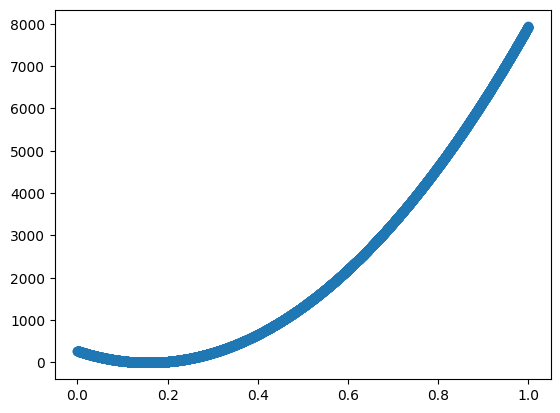

In [28]:
# Preparing a dataset of a function with some random noise
# to make as realistic as possible

number_of_datapoints = 5000
x = np.linspace(-10, 50, number_of_datapoints).reshape(-1, 1)
y = 3.1 * np.power(x, 2) + 3.7 * x

scaler = MinMaxScaler()
scaler.fit(x)
x = scaler.transform(x)

plt.scatter(x, y)

In [29]:
# Splitting the data to train, test, and validation datasets

x_train, x_rest, y_train, y_rest =           train_test_split(x, y, test_size=0.3)
x_test, x_validation, y_test, y_validation = train_test_split(x_rest, y_rest, test_size=0.5)

x_train      = torch.tensor(x_train, dtype=torch.float32).reshape(-1, 1)
x_test       = torch.tensor(x_test, dtype=torch.float32).reshape(-1, 1)
x_validation = torch.tensor(x_validation, dtype=torch.float32).reshape(-1, 1)
y_train      = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
y_test       = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
y_validation = torch.tensor(y_validation, dtype=torch.float32).reshape(-1, 1)

x_train.shape, x_test.shape, x_validation.shape

(torch.Size([3500, 1]), torch.Size([750, 1]), torch.Size([750, 1]))

In [30]:
x_train[0], y_train[0]

(tensor([0.7720]), tensor([4223.0991]))

In [31]:
model = nn.Sequential(
  nn.Linear(1, 64),
  nn.ReLU(),

  nn.Linear(64, 64),
  nn.ReLU(),

  nn.Linear(64, 64),
  nn.ReLU(),

  nn.Linear(64, 1),
)

In [32]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
best_model  = None
lowest_loss = inf
history = []

In [33]:
for _ in range(5_000):
  model.train()
  optimizer.zero_grad()
  output = model(x_train)
  loss = criterion(output, y_train)
  loss.backward()
  optimizer.step()

  if _ % 10 ==0:
    print(f"Loss on the epoch {_} is {loss}")

  model.eval()
  output = model(x_test)
  test_loss = criterion(y_test, output)
  history.append(test_loss)

  if test_loss.item() < lowest_loss:
    lowest_loss = test_loss
    best_model  = model

Loss on the epoch 0 is 10303532.0
Loss on the epoch 10 is 10301231.0
Loss on the epoch 20 is 10297486.0
Loss on the epoch 30 is 10289961.0
Loss on the epoch 40 is 10275914.0
Loss on the epoch 50 is 10251342.0
Loss on the epoch 60 is 10210742.0
Loss on the epoch 70 is 10147105.0
Loss on the epoch 80 is 10051806.0
Loss on the epoch 90 is 9914188.0
Loss on the epoch 100 is 9722472.0
Loss on the epoch 110 is 9464245.0
Loss on the epoch 120 is 9127322.0
Loss on the epoch 130 is 8701877.0
Loss on the epoch 140 is 8184399.5
Loss on the epoch 150 is 7580157.5
Loss on the epoch 160 is 6905094.5
Loss on the epoch 170 is 6188890.0
Loss on the epoch 180 is 5475307.5
Loss on the epoch 190 is 4819583.0
Loss on the epoch 200 is 4275760.0
Loss on the epoch 210 is 3878493.0
Loss on the epoch 220 is 3625648.5
Loss on the epoch 230 is 3477351.75
Loss on the epoch 240 is 3381363.25
Loss on the epoch 250 is 3301899.75
Loss on the epoch 260 is 3225307.75
Loss on the epoch 270 is 3149242.75
Loss on the epoch

In [34]:
lowest_loss

tensor(11.2360, grad_fn=<MseLossBackward0>)

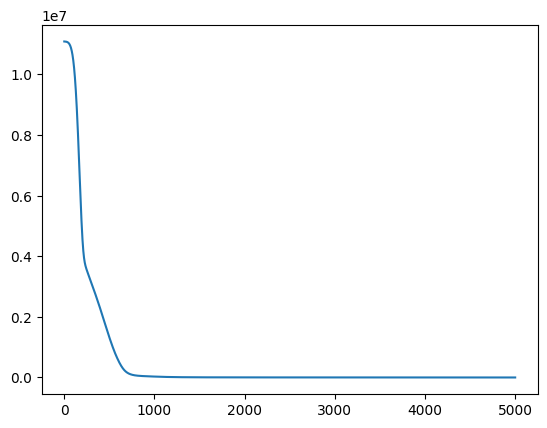

In [35]:
plt.plot([item.item() for item in history])

In [36]:
with torch.inference_mode():
  print(best_model(prepare_input(12.3, scaler)), f(12.3))

tensor([[514.1875]]) 514.5090000000001


# Creating Ensembles

In [38]:
ensemble_count = 30
batch_size = 750 // 5

750

In [39]:
# Initialize a variable for storing different to-be-created models

models = []

for _ in range(ensemble_count):
  indices = random.sample(range(len(x_validation)), batch_size)
  x_batch = x_validation[indices]
  y_batch = y_validation[indices]

  copied_model = deepcopy(best_model)

  optimizer = optim.Adam(copied_model.parameters(), lr=0.0001)
  copied_model.train()

  optimizer.zero_grad()
  output = copied_model(x_batch)
  loss = criterion(output, y_batch)
  loss.backward()
  optimizer.step()

  print(loss)

  models.append(copied_model)

tensor(10.2215, grad_fn=<MseLossBackward0>)
tensor(6.2419, grad_fn=<MseLossBackward0>)
tensor(13.9851, grad_fn=<MseLossBackward0>)
tensor(10.1122, grad_fn=<MseLossBackward0>)
tensor(8.9949, grad_fn=<MseLossBackward0>)
tensor(10.5420, grad_fn=<MseLossBackward0>)
tensor(11.9007, grad_fn=<MseLossBackward0>)
tensor(8.3237, grad_fn=<MseLossBackward0>)
tensor(9.8730, grad_fn=<MseLossBackward0>)
tensor(8.1466, grad_fn=<MseLossBackward0>)
tensor(15.5530, grad_fn=<MseLossBackward0>)
tensor(7.2100, grad_fn=<MseLossBackward0>)
tensor(7.3032, grad_fn=<MseLossBackward0>)
tensor(9.6596, grad_fn=<MseLossBackward0>)
tensor(10.4731, grad_fn=<MseLossBackward0>)
tensor(10.1521, grad_fn=<MseLossBackward0>)
tensor(10.6997, grad_fn=<MseLossBackward0>)
tensor(16.5951, grad_fn=<MseLossBackward0>)
tensor(8.2613, grad_fn=<MseLossBackward0>)
tensor(10.4121, grad_fn=<MseLossBackward0>)
tensor(7.6450, grad_fn=<MseLossBackward0>)
tensor(10.4698, grad_fn=<MseLossBackward0>)
tensor(8.9793, grad_fn=<MseLossBackward0>)

In [41]:
def infer(models, ix):
  predictions = []
  with torch.inference_mode():
    for model in models:
      predictions.append(model(prepare_input(ix, scaler)).item())
  return mean(predictions)

In [44]:
test_input = 20
truth = f(test_input)

ensemble_prediction = infer(models, test_input)
best_model_prediction = best_model(prepare_input(test_input, scaler))

ensemble_loss   = (ensemble_prediction - truth) ** 2
best_model_loss = (best_model_prediction - truth) ** 2

improvement = best_model_loss - ensemble_loss

improvement

tensor([[0.0540]], grad_fn=<SubBackward0>)